In [1]:
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
import netCDF4 as nc
import ipywidgets as widgets
import json
import datetime

In [2]:
def statistic_of_ensemble(mu, var, scale, num_samples=10000):
    x = np.arange(mu.shape[1])
    y = np.arange(mu.shape[0])

    rng = np.random.default_rng()

    result_x = []
    result_mu = []
    result_var = []

    for i in range(mu.shape[0] - 1):
        for j in range(mu.shape[1] - 1):
            f_subset = mu[i:i+2, j:j+2].flatten()
            var_subset = var[i:i+2, j:j+2].flatten()
            std_subset = np.sqrt(var_subset)

            samples = np.array([rng.normal(m, std, num_samples) for m,std in zip(f_subset, std_subset)]).T

            samples_interpolant = [interpolate.interp2d(x[j:j+2], y[i:i+2], samp) for samp in samples]

            x_interpolated = np.linspace(x[j], x[j + 1], scale + 1)
            y_interpolated = np.linspace(y[i], y[i + 1], scale + 1)

            s_interpolated = np.transpose(np.meshgrid(x_interpolated, y_interpolated), [1,2,0])
            samples_interpolated = np.array([interpolant(x_interpolated, y_interpolated) for interpolant in samples_interpolant])

            mu_interpolated = np.mean(samples_interpolated, axis=0).T
            var_interpolated = np.var(samples_interpolated, axis=0).T

            result_x.append(s_interpolated)
            result_mu.append(mu_interpolated)
            result_var.append(var_interpolated)

    return result_x, result_mu, result_var

In [3]:
ds = nc.Dataset('../../../Data/weather/netcdf/day20_200_temp.nc')
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2009-05-20 11:30:32 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(144), latitude(73), number(9), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 number(number), int32 time(time), int16 cnrm(time, number, latitude, longitude), int16 crfc(time, number, latitude, longitude), int16 lody(time, number, latitude, longitude), int16 scnr(time, number, latitude, longitude), int16 scwf(time, number, latitude, longitude), int16 smpi(time, number, latitude, longitude), int16 ukmo(time, number, latitude, longitude)
    groups: 


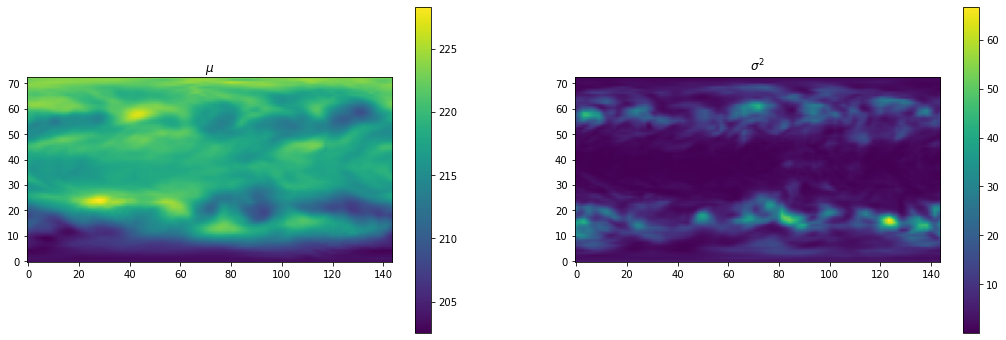

In [34]:
sim = 'ukmo'
samples = ds[sim][0]

mean = np.mean(samples, axis=0)
var = np.var(samples, axis=0)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean, origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var, origin='lower')
plt.colorbar()

plt.show()

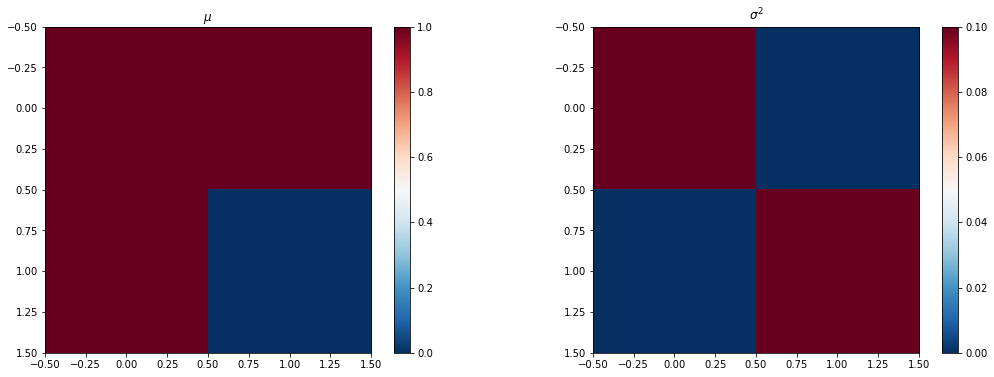

[[1 1]
 [1 0]]


In [98]:
mean_subset = np.array([
    [1, 1],
    [1, 0]
])
var_subset = np.array([
    [0.1, 0],
    [0, 0.1]
])

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean_subset, cmap='RdBu_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_subset, cmap='RdBu_r')
plt.colorbar()

plt.show()

print(mean_subset)

In [99]:
scale = 8
s2, mu2, var2 = statistic_of_ensemble(mean_subset, var_subset, scale, 1000)

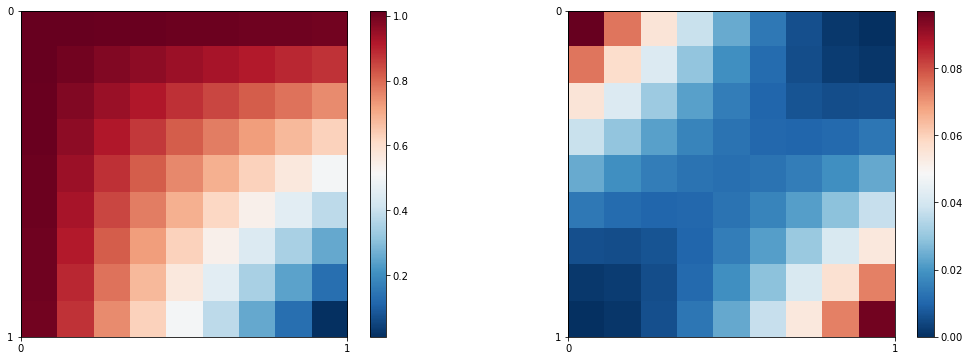

In [100]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
for m,s in zip(mu2,s2):
    extent = [
        s[0,0,0] * scale,
        s[0,-1,0] * scale,
        s[-1,0,1] * scale,
        s[0,0,1] * scale
    ]

    img1 = ax1.imshow(m, cmap='RdBu_r', extent=extent, origin='upper', vmin=np.min(mu2), vmax=np.max(mu2), interpolation='none')
ax1.set_xticks(np.arange(0, (mean_subset.shape[1] - 1) * scale + 1, scale))
ax1.set_xticklabels(np.arange(mean_subset.shape[1]))
ax1.set_yticks(np.arange(0, (mean_subset.shape[0] - 1) * scale + 1, scale))
ax1.set_yticklabels(np.arange(mean_subset.shape[0]))
ax1.set_xlim(0, (mean_subset.shape[1] - 1) * scale)
ax1.set_ylim(0, (mean_subset.shape[0] - 1) * scale)
ax1.axes.invert_yaxis()
plt.colorbar(img1, ax=ax1)
plt.grid(c='k', lw=1)

ax2 = plt.subplot(1,2,2)
for m,s in zip(var2,s2):
    extent = [
        s[0,0,0] * scale,
        s[0,-1,0] * scale,
        s[-1,0,1] * scale,
        s[0,0,1] * scale
    ]

    img2 = ax2.imshow(m, cmap='RdBu_r', extent=extent, origin='upper', vmin=np.min(var2), vmax=np.max(var2), interpolation='none')
ax2.set_xticks(np.arange(0, (mean_subset.shape[1] - 1) * scale + 1, scale))
ax2.set_xticklabels(np.arange(mean_subset.shape[1]))
ax2.set_yticks(np.arange(0, (mean_subset.shape[0] - 1) * scale + 1, scale))
ax2.set_yticklabels(np.arange(mean_subset.shape[0]))
ax2.set_xlim(0, (mean_subset.shape[1] - 1) * scale)
ax2.set_ylim(0, (mean_subset.shape[0] - 1) * scale)
ax2.axes.invert_yaxis()
plt.colorbar(img2, ax=ax2)
plt.grid(c='k', lw=1)

plt.show()

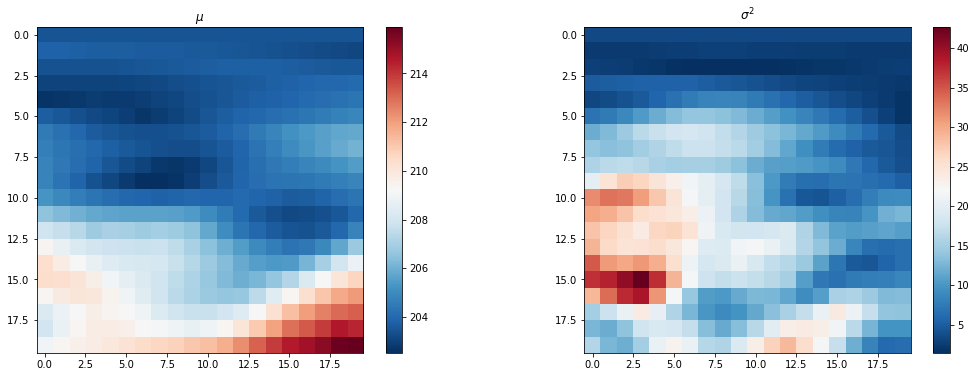

In [35]:
mean_subset = mean[:20,:20]
var_subset = var[:20,:20]

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean_subset, cmap='RdBu_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_subset, cmap='RdBu_r')
plt.colorbar()

plt.show()

In [36]:
scale = 8
num_samples = 10000
s2, mu2, var2 = statistic_of_ensemble(mean_subset, var_subset, scale, num_samples)

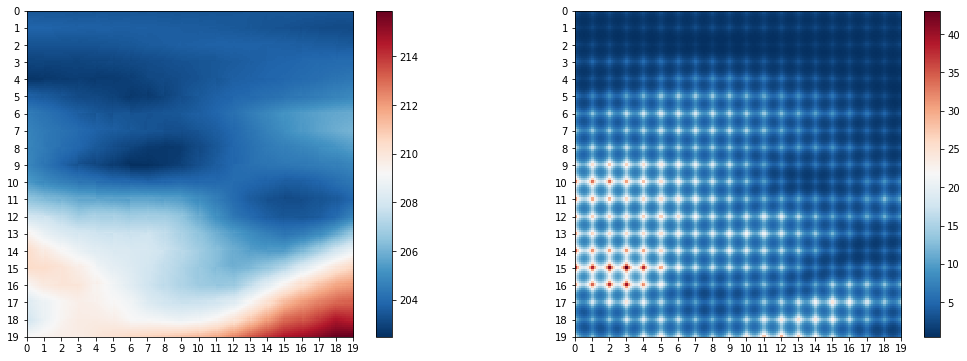

In [37]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
for m,s in zip(mu2,s2):
    extent = [
        s[0,0,0] * scale,
        s[0,-1,0] * scale,
        s[-1,0,1] * scale,
        s[0,0,1] * scale
    ]

    img1 = ax1.imshow(m, cmap='RdBu_r', extent=extent, origin='upper', vmin=np.min(mu2), vmax=np.max(mu2), interpolation='none')
ax1.set_xticks(np.arange(0, (mean_subset.shape[1] - 1) * scale + 1, scale))
ax1.set_xticklabels(np.arange(mean_subset.shape[1]))
ax1.set_yticks(np.arange(0, (mean_subset.shape[0] - 1) * scale + 1, scale))
ax1.set_yticklabels(np.arange(mean_subset.shape[0]))
ax1.set_xlim(0, (mean_subset.shape[1] - 1) * scale)
ax1.set_ylim(0, (mean_subset.shape[0] - 1) * scale)
ax1.axes.invert_yaxis()
plt.colorbar(img1, ax=ax1)
#plt.grid(c='k', lw=1)

ax2 = plt.subplot(1,2,2)
for m,s in zip(var2,s2):
    extent = [
        s[0,0,0] * scale,
        s[0,-1,0] * scale,
        s[-1,0,1] * scale,
        s[0,0,1] * scale
    ]

    img2 = ax2.imshow(m, cmap='RdBu_r', extent=extent, origin='upper', vmin=np.min(var2), vmax=np.max(var2), interpolation='none')
ax2.set_xticks(np.arange(0, (mean_subset.shape[1] - 1) * scale + 1, scale))
ax2.set_xticklabels(np.arange(mean_subset.shape[1]))
ax2.set_yticks(np.arange(0, (mean_subset.shape[0] - 1) * scale + 1, scale))
ax2.set_yticklabels(np.arange(mean_subset.shape[0]))
ax2.set_xlim(0, (mean_subset.shape[1] - 1) * scale)
ax2.set_ylim(0, (mean_subset.shape[0] - 1) * scale)
ax2.axes.invert_yaxis()
plt.colorbar(img2, ax=ax2)
#plt.grid(c='k', lw=1)

plt.show()

In [38]:
manifest = {
    'files': [
        'soe-day20_200_temp-{:s}-s.npy'.format(sim),
        'soe-day20_200_temp-{:s}-mu.npy'.format(sim),
        'soe-day20_200_temp-{:s}-var.npy'.format(sim)
    ],
    'creator': 'Viktor Leonhardt <leonhardt@cs.uni-kl.de>',
    'date': datetime.datetime.now().__str__(),
    'description': 'Contains the interpolated temperature of the DEMETER project, while only the first 20 x 20 points of the simulation `{:s}` are used to build a random normal field. Each cell is drawn from the random number to interpolate the samples, taking the mean/variance and the files contain the sampled points `s`, the mean `mu` and the variance `var`.'.format(sim),
    'parameters': {
        'scale': scale,
        'num_samples': num_samples
    },
    'generator': 'uncertainty-vis/Experiments/interpolation/weather/KDE.ipynb'
}
with open('../../../Data/weather/interpolation/soe-day20_200_temp-{:s}.manifest'.format(sim), 'w') as f:
    f.write(json.dumps(manifest, indent=2))

np.save('../../../Data/weather/interpolation/soe-day20_200_temp-{:s}-s.npy'.format(sim), s2)
np.save('../../../Data/weather/interpolation/soe-day20_200_temp-{:s}-mu.npy'.format(sim), mu2)
np.save('../../../Data/weather/interpolation/soe-day20_200_temp-{:s}-var.npy'.format(sim), var2)